Importing useful libraries and importing the drive for the dataset

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest

import math

from sklearn import preprocessing

from scipy import stats
import scipy as sci

import random

import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV

from scipy.spatial.distance import minkowski

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


Importing the data

In [ ]:
pddata = pd.read_csv('GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip', error_bad_lines=False, skiprows=1)

In [ ]:
pddata = pddata.to_numpy()
RelKa = pddata[:, -1]
training_data = pddata[:, 2:-1]

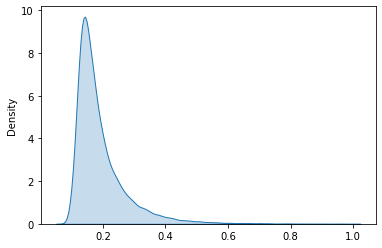

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.kdeplot(RelKa, fill=True)
plt.show()
plt.savefig("RelKas.png")

Some helpers function for the analysis below

In [ ]:
def drop_outliers(x, y, outliers):
  x = np.delete(x, outliers, axis=0)
  y = np.delete(y, outliers, axis=0)
  return x, y

In [ ]:
def split_RelKa(y, p):
  return np.array([1 if value > p else 0 for value in y])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def predict_with_Random_Forests(X_train, X_test, y_train, y_test):
  clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)  
  return y_pred

In [ ]:
from sklearn import metrics

def return_accuracy(y_test, y_pred, verbose=1):
  C = metrics.confusion_matrix(y_test, y_pred)
  accuracy = np.trace(C) / len(y_test)
  if verbose == 1:
    print("The number of true negatives is:", C[0, 0])
    print("The number of false negatives is:", C[1,0])
    print("The number of false positives is:", C[0,1])  
    print("The number of true positives is:", C[1,1])
    print("The accuracy is:", accuracy)
    print("The accuracy on the 1's is ", 1 / np.sum(y_test == 1) * (np.sum(y_test == 1) - C[1, 0]))
    print("The accuracy on the 0's is ", 1 / np.sum(y_test == 0) * (np.sum(y_test == 0) - C[0, 1]))
  return accuracy

In [ ]:
def split_outliers(threshold, scores):
  """
  As a consequence of the histogram below, we change the decision function 
  implemented in the isolation forests if the 
  Anomaly_Detection_Isolation_Forests function is told to do so
  """
  outliers_indices = np.where(scores <= threshold)[0]
  return outliers_indices

In [ ]:
import random

def undersampling(X, y, ratios = np.array([0.1, 0.2, 0.2]), intervals = 0.2 * np.arange(0, 4)):
  undersampled_training_data = np.zeros(training_data.shape[1])
  undersampled_training_data = undersampled_training_data[..., np.newaxis].T
  undersampled_RelKa = np.array([])
  for i in range(len(intervals)-1):
      indices = np.where(np.logical_and(intervals[i] <= RelKa, RelKa <= intervals[i+1]))[0]
      sample_length = np.int(ratios[i]*len(indices))
      random_picked = random.sample(list(np.arange(0, len(indices) + 1)), sample_length)
      training_to_add = training_data[indices[0] + random_picked, :]
      undersampled_training_data = np.concatenate([undersampled_training_data, training_to_add], axis=0)
      RelKa_to_add = RelKa[indices[0] + random_picked]
      undersampled_RelKa = np.concatenate([undersampled_RelKa, RelKa_to_add], axis=0)
  critical_indices = np.where(RelKa >= 0.7)[0]
  critical_RelKa = RelKa[critical_indices]
  critical_samples = training_data[critical_indices, :]
  undersampled_training_data = np.concatenate([undersampled_training_data, critical_samples], axis=0)
  undersampled_RelKa = np.concatenate([undersampled_RelKa, critical_RelKa], axis=0)
  undersampled_training_data = np.delete(undersampled_training_data, 0, axis=0)
  return undersampled_training_data, undersampled_RelKa

In [ ]:
from sklearn import metrics

def weighted_balance_average(y_true, y_pred):
    ones_number = np.count_nonzero(y_true == 1.)
    frequency_1 = ones_number / len(y_true)
    frequency_0 = 1 - frequency_1
    sum_inverse_frequencies = 1 / frequency_0 + 1 / frequency_1
    weight_0 = 1 / (frequency_0 * sum_inverse_frequencies)
    weight_1 = 1 / (frequency_1 * sum_inverse_frequencies)
    C = metrics.confusion_matrix(y_true, y_pred)
    return weight_0 * C[0, 0] / (C[0, 0] + C[0, 1]) + weight_1 * C[1, 1] / (C[1, 1] + C[1, 0])

In [ ]:
from sklearn import metrics

def jaccard_score(y_true, y_pred):
    C = metrics.confusion_matrix(y_true, y_pred)
    return C[1, 1] / (C[1, 1] + C[1, 0] + C[0, 1])

WE FIRTS TRY TO DO A PREDICTION WITHOUT ANY OUTLIER REMOTION TO HAVE A COMPARISON

In [ ]:
from sklearn.preprocessing import StandardScaler

RelKa_tilda = split_RelKa(RelKa, 0.7)
indices = [i for i in range(len(training_data))]
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(training_data, RelKa_tilda, indices, train_size=0.7, random_state=42)

In [ ]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = weighted_balance_average(y_test, y_pred)
print(accuracy)

0.8447460428034289


WE SEE THAT THE ACCURACY IS HIGH BUT WE ARE PREDICTING VERY POORLY THE CLASS 1

ISOLATION FORESTS ANOMALY DETECTION

In [ ]:
from sklearn.ensemble import IsolationForest

def Anomaly_Detection_Isolation_Forests(x, change_split=True):
  random_state = np.random.RandomState(42)
  contamination = 'auto'
  threshold = np.random.uniform(-0.03, -0.02, 1)
  model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
  model.fit(x)
  scores = model.decision_function(x)
  if change_split == False:
    anomaly_score = model.predict(x)
    outliers_indices = np.where(anomaly_score == -1)[0]
  if change_split == True:
    outliers_indices = split_outliers(threshold, scores)
  return contamination, scores, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
  tol = 1.0e-02
  if contamination != 'auto':
    outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
    assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
  indecision_percentage = 1 / len(RelKa) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p,  "is", indecision_percentage)
    print("The percentage of outliers detected is", 1 / len(scores) * len(np.where(scores < 0)[0]))

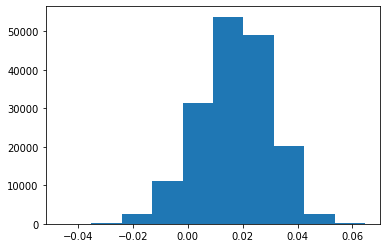

The indecision percentage around 0.02 is 0.5672001406964474
The percentage of outliers detected is 0.10294290069175753


In [ ]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(training_data, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [ ]:
training_data, RelKa = drop_outliers(training_data, RelKa, outliers_indices)
RelKa_tilda = split_RelKa(RelKa, 0.7)

In [ ]:
indices = [i for i in range(len(training_data))]
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(training_data, RelKa_tilda, indices, train_size=0.7, random_state=42)

In [ ]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 45799
The number of false negatives is: 59
The number of false positives is: 11
The number of true positives is: 37
The accuracy is: 0.9984751448612382
The accuracy on the 1's is  0.38541666666666663
The accuracy on the 0's is  0.9997598777559485


We see that we have a problem with a large number of false negatives, namely with incorrectly predictions of the negative class

# CROSS VALIDATION (5-FOLD) TO FINETUNE THE RF PARAMETERS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, train_size=0.7, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 3, cv = 5, scoring=make_scorer(weighted_balance_average), verbose=10)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=200...
[CV 1/5; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.751 total time= 5.9min
[CV 2/5; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=200...
[CV 2/5; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.941 total time= 5.5min
[CV 3/5; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=200...
[CV 3/5; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.909 total time= 5.4min
[CV 4/5; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=200...
[CV 4/5; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.737 total time= 5.2min
[CV 5/5; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=200...
[CV 5/5; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=1.000 total tim

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=3,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 125, 150, 175,
                                                         200]},
                   scoring=make_scorer(weighted_balance_average), verbose=10)

In [ ]:
print(rf_random.best_params_)

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2}


In [ ]:
clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=2, min_samples_split=5, criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 45799
The number of false negatives is: 60
The number of false positives is: 11
The number of true positives is: 36
The accuracy is: 0.9984533612163987
The accuracy on the 1's is  0.375
The accuracy on the 0's is  0.9997598777559485


WE TRY PERFORMING K-MEANS CLUSTERING FIRST

In [ ]:
max_iters = 5
threshold = 1.0e-02
k = 5
indices = np.where(RelKa <= 0.2)[0]
redundant_training_data = training_data[indices, :]
redundant_RelKa = RelKa[indices]

average_loss, assignments = kmeans(redundant_training_data, k, max_iters, threshold)

In [ ]:
import random

clustered_data = np.zeros(training_data.shape[1])
clustered_data = clustered_data[..., np.newaxis].T
clustered_RelKa = np.array([])
for i in range(k):
    # collect random_size casual samples from the i-th cluster
    assigned_indices = np.where(assignments == i)[0]
    # taking the samples and RelKa assigned to the i-th cluster
    assigned_data = redundant_training_data[assigned_indices, :]
    assigned_RelKa = redundant_RelKa[assigned_indices]
    # taking a random subsample
    random_picked = random.sample(list(np.arange(0, len(assigned_indices))), np.int(1/10 * len(assigned_indices)))
    data_to_add = assigned_data[random_picked, :]
    RelKa_to_add = assigned_RelKa[random_picked]
    # concatenate the subsample to the old clustered_data and clustered_RelKa
    clustered_data = np.concatenate([clustered_data, data_to_add])
    clustered_RelKa = np.concatenate([clustered_RelKa, RelKa_to_add])
# we delete the first row which was just for initialization
clustered_data = np.delete(clustered_data, 0, axis = 0)

In [ ]:
# adding all the other samples (which represent less than 20% of the original dataset)
indices = np.where(RelKa > 0.2)[0]
clustered_data = np.concatenate([clustered_data, training_data[indices, :]])
clustered_RelKa = np.concatenate([clustered_RelKa, RelKa[indices]])

In [ ]:
clustered_RelKa = split_RelKa(clustered_RelKa, 0.6)
clustered_data = standardize(clustered_data)

In [ ]:
clustered_X_train, clustered_X_test, clustered_y_train, clustered_y_test = train_test_split(clustered_data, clustered_RelKa, train_size=0.7, random_state=42)
clustered_y_pred = predict_with_Random_Forests(clustered_X_train, clustered_X_test, clustered_y_train, clustered_y_test)
return_accuracy(clustered_y_test, clustered_y_pred, verbose=1)

UNDERSAMPLING AND OVERSAMPLING CROSS-VALIDATION TECHNIQUE

In [ ]:
def split_importance(x, y, importance_class=0.7):
  """
  Split the samples into interesting ones and not interesting ones
  :param x: numpy.ndarray:the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param importance_class: float: the lower bound for the underepresented class
  """
  return x[y >= importance_class], y[y >= importance_class], x[y < importance_class], y[y < importance_class]

In [ ]:
x_1, y_1, x_0, y_0 = split_importance(training_data, RelKa)

In [ ]:
# split the two classes seperately into train and test set to ensure representation of the minority class
# both in the test set and in the train set
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size=0.4, random_state=42)
x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_0, y_0, test_size=0.4, random_state=42)

x_train = np.concatenate((x_1_train, x_0_train))
y_train = np.concatenate((y_1_train, y_0_train))
x_test = np.concatenate((x_1_test, x_0_test))
y_test = np.concatenate((y_1_test, y_0_test))

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
y_train = split_RelKa(y_train, 0.7)
y_test = split_RelKa(y_test, 0.7)

In [ ]:
#quantization function required for some score functions
def quantize(x,cuts=100):
  ranges = np.sort(np.unique(pd.cut(x,cuts)))
  for i in range(ranges.shape[0]):
    ranges_i = ranges[i]
    x[(x<=ranges_i.right)&(x>ranges_i.left)] = (ranges_i.left +ranges_i.right)/2
  return x

def quantize_features(x,cuts=100):
  return np.apply_along_axis(quantize,0,x,cuts)

#correlation scorers
def Spearman(i,j):
  ret,_ = spearmanr(i,j)
  return ret

def Correlation_Score(x,y):
  x = x.T
  score = [min([abs(Spearman(j,i)) for i in x]) for j in x]
  return np.array(score)

def Correlation_Score_Max(x,y):
  x = x.T
  score = [-max([abs(Spearman(j,i)) for i in x]) for j in x]
  return np.array(score)

In [ ]:
def Furthest(x,z):
  """
  Returns the index of the sample in x which is furthest from all the samples in z
  :param x: numpy.ndarray: The array of the samples for which we seek to find the furthest
  :param z: numpy.ndarray: The array of the samples which we use as a point of reference
  :return: int: returns a single index corresponding to the furthest x
  """
  distances = []
  for i in range(x.shape[0]):
    distance = min([np.linalg.norm(j-x[i]) for j in z])
    distances.append(distance)
  return np.argmin(distances)

def PSU_undersampling(x,y,randomsize,xi,yi):
  """
  This function calculates the PSU undersampling of the samples in the x,y arrays
  with regards to the set xi,yi
  :param x: numpy.ndarray: The array of samples, which we want to undersample
  :param y: numpy.ndarray: The array with the labels corresponding to the samples in x
  :param randomsize: int: An int corresponding to the number of samples to be left
  :param xi: numpy.ndarray: The array with the samples to be used as a reference for distances
  :param yi: numpy.ndarray: The labels of these samples
  :return: numpy.ndarray,numpy.ndarray: Returns 2 numpy arrays corresponding to the undersampled data
  """
  C = np.mean(x,axis = 0)
  dist = np.linalg.norm(x-C,2,axis = 1)
  indices = dist.argsort()
  x = x[indices]
  y = y[indices]
  split_x = np.array_split(x,randomsize)
  split_y = np.array_split(y,randomsize)
  indices = [Furthest(split_x[i],xi) for i in range(randomsize)]
  x_resample = np.array([split_x[i][indices[i]] for i in range(randomsize)])
  y_resample = np.array([split_y[i][indices[i]] for i in range(randomsize)])
  return x_resample, y_resample

def PSU_undersampling_reduced_dim(x,y,randomsize,xi,yi):
  """
  This function calculates the PSU undersampling by first doing a dimensionality reduction
  of the samples in the x,y arrays with regards to the set xi,yi
  :param x: numpy.ndarray: The array of samples, which we want to undersample
  :param y: numpy.ndarray: The array with the labels corresponding to the samples in x
  :param randomsize: int: An int corresponding to the number of samples to be left
  :param xi: numpy.ndarray: The array with the samples to be used as a reference for distances
  :param yi: numpy.ndarray: The labels of these samples
  :return: numpy.ndarray,numpy.ndarray: Returns 2 numpy arrays corresponding to the undersampled data
  """
  feature_scores =  Fisher_Score(xi,x)
  indices = np.sort((-feature_scores).argsort()[:10])
  x_filtered = x[:,indices]
  x_i = xi[:,indices]
  C = np.mean(x_filtered,axis = 0)
  dist = np.linalg.norm(x_filtered-C,2,axis = 1)
  indices = dist.argsort()
  x_filtered = x_filtered[indices]
  y = y[indices]
  split_x = np.array_split(x_filtered,randomsize)
  split_y = np.array_split(y,randomsize)
  indices = [Furthest(split_x[i],x_i) for i in range(randomsize)]
  split_x = np.array_split(x,randomsize)
  x_resample = np.array([split_x[i][indices[i]] for i in range(randomsize)])
  y_resample = np.array([split_y[i][indices[i]] for i in range(randomsize)])
  return x_resample, y_resample

In [ ]:
def Fisher_Score(x_import, x_nimport):
  """
  Given two arrays of two classes this function calculates the Fischer_scores to 
  measure the significance for all features
  :param x_import: numpy.ndarray: the array containing the samples of one class
  :param x_nimport: numpy.ndarray: the array containing the samples of the other class
  :return: numpy.ndarray: returns an array containg the Fisher_Score for all features 
  """
  mean_import = np.mean(x_import,axis = 0)
  mean_nimport = np.mean(x_nimport,axis = 0)
  mean_dist = np.absolute(mean_import-mean_nimport)
  std_import = np.std(x_import,axis=0)
  std_nimport = np.std(x_nimport,axis=0)
  std_sum = std_import+std_nimport
  #return std_sum
  return np.divide(mean_dist,std_sum)

def calculate_distances(x, distance):
  """
  Calculates the distance between any two pairs of the set x using 
  the Minkowski distance of degree distance.
  :param x: numpy.ndarray: the vector for which we will calculate the distance 
                            between all of its elements 
  :param distance: float: the norm which should be used for the Minkowski distance
  :return: numpy.ndarray: returns the Minkowski distance with the specified norm 
                          between all pairs of elements in x 
  """
  dist = np.array([[minkowski(a1,a2,distance) for a2 in x] for a1 in x])
  np.fill_diagonal(dist,float('inf'))
  return dist

def random_sampler(x, y, randomsize):
  """
  This function does random undersampling of vectors x,y and reduces them to 
  size random size
  :param x: numpy.ndarray: the feature vector to be subsampled
  :param y: numpy.ndarray: the label vector to be subsampled
  :return: <class 'tuple'>: A tuple containing the two undersampled vectors
  """
  p = np.random.permutation(len(y))
  new_x = x[p]
  new_y = y[p]
  return new_x[:randomsize],new_y[:randomsize]

def generate_samples(x, y, neighbors, N):
  """
  This function generate N samples which are convex combinations of 
  the features of x and the labels of y
  :param x: numpy.ndarray:
  :param y: numpy.ndarray:
  :return: <class 'tuple'>:
  """
  new_samples_x = []
  new_samples_y = []
  for i in range(N):
    random_sample_i = random.randint(0,y.shape[0]-1)
    x_i = x[random_sample_i]
    random_sample_j = random.randint(0,neighbors.shape[1]-1)
    neigh_i = neighbors[random_sample_i,random_sample_j]
    x_j = x[neigh_i]
    lambda_ = random.uniform(0,1)
    y_i = y[random_sample_i]
    y_j = y[neigh_i]
    new_x = x_i + lambda_*(x_j-x_i)
    new_y = y_i + lambda_*(y_j-y_i)
    new_samples_x.append(new_x)
    new_samples_y.append(new_y)
  return np.array(new_samples_x),np.array(new_samples_y)

def random_sampler(x,y,randomsize):
  """
  This function does random undersampling of vectors x,y and reduces them to 
  size random size
  :param x: numpy.ndarray: the feature vector to be subsampled
  :param y: numpy.ndarray: the label vector to be subsampled
  :return: <class 'tuple'>: A tuple containing the two undersampled vectors
  """
  p = np.random.permutation(len(y))
  new_x = x[p]
  new_y = y[p]
  return new_x[:randomsize],new_y[:randomsize]

def generate_samples(x,y,neighbors,N):
  """
  This function generate N samples which are convex combinations of 
  the features of x and the labels of y
  :param x: numpy.ndarray:
  :param y: numpy.ndarray:
  :return: <class 'tuple'>:
  """
  new_samples_x = []
  new_samples_y = []
  for i in range(N):
    random_sample_i = random.randint(0,y.shape[0]-1)
    x_i = x[random_sample_i]
    random_sample_j = random.randint(0,neighbors.shape[1]-1)
    neigh_i = neighbors[random_sample_i,random_sample_j]
    x_j = x[neigh_i]
    lambda_ = random.uniform(0,1)
    y_i = y[random_sample_i]
    y_j = y[neigh_i]
    new_x = x_i + lambda_*(x_j-x_i)
    new_y = y_i + lambda_*(y_j-y_i)
    new_samples_x.append(new_x)
    new_samples_y.append(new_y)
  return np.array(new_samples_x),np.array(new_samples_y)

def smote_sf(x, y, undersample=0.5, oversample = 0.1, attribute_scorer=Fisher_Score, 
             attribute_number = 10, distance = float('inf'), kneighbors = 3,
             undersampling = random_sampler, importance_class = 0.7):
  """
  This function takes the complete input and produces a more balanced dataset based on the importance class
  :param x: numpy.ndarray: the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param undersample: float: the percentage of the dominant class that we want to keep
  :param oversample: float: the percentage of the dataset that the small class will be at the end
  :param attribute_scorer: function: a function which will be used to score the relevance of a feature
  :param attribute_number: int: the number of attributes to keep according to their score
  :param distance: float: the norm which should be used for the Minkowski distance
  :param kneighbors: int: the number of samples which should be considered for each point 
  :param undersampling: function: the function to use for the undersampling of the majority class
  :param importance_class: float: the lower bound for the underepresented class
  :return: returns 2 new feature vectors and 2 new label vectors containing 
            the data for the importance class and the data for the non importance 
            class and their labels. 
  """
  x_import = x[y>=importance_class]
  y_import = y[y>=importance_class]
  x_nimport = x[y<importance_class]
  y_nimport = y[y<importance_class]

  feature_scores =  attribute_scorer(x_import,x_nimport)
  #find the attribute_number highest coordinates of the feature_scores vector
  indices = np.sort((-feature_scores).argsort()[:attribute_number])
  x_import_filtered = x_import[:,indices]
  #x_nimport = x_nimport[:,indices]
  distances = calculate_distances(x_import_filtered,distance)
  #find the k lowest indices
  neighbors = np.array([ np.sort(d.argsort()[:(kneighbors)]) for d in distances])
  #undersampling for the majority class
  nimport_len = int(undersample*y_nimport.shape[0])
  x_nimport,y_nimport = undersampling(x_nimport,y_nimport,nimport_len, x_import,y_import)
  #Calculate the number of samples to be generated
  N = int(oversample*(y_nimport.shape[0]) - y_import.shape[0])
  #Generate N new samples
  new_samples_x,new_samples_y = generate_samples(x_import, y_import, neighbors, N)
  #merge the new samples of the minority class with its old samples
  x_import = np.concatenate((x_import,new_samples_x))
  y_import = np.concatenate((y_import,new_samples_y))

  x_ret = np.concatenate((x_import, x_nimport))
  y_ret = np.concatenate((y_import, y_nimport))
  return x_ret, y_ret

In [ ]:
x_train, y_train = smote_sf(x_train, y_train, undersample=0.1, oversample=0.5, kneighbors=5, undersampling = PSU_undersampling)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 10, scoring=make_scorer(weighted_balance_average), verbose=10)
rf_random.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=100.
[CV 1/10; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.957 total time=  20.1s
[CV 2/10; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=100.
[CV 2/10; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.995 total time=  20.6s
[CV 3/10; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=100.
[CV 3/10; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.996 total time=  20.3s
[CV 4/10; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=100.
[CV 4/10; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.997 total time=  21.2s
[CV 5/10; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=100.
[CV 5/10; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 111, 122, 133,
                                                         144, 155, 166, 177,
                                                         188, 200]},
                   scoring=make_scorer(weighted_balance_average), verbose=10)

In [ ]:
print(rf_random.best_params_)

{'n_estimators': 144, 'min_samples_split': 2, 'min_samples_leaf': 1}


The number of true negatives is: 68032
The number of false negatives is: 46
The number of false positives is: 70
The number of true positives is: 84
The accuracy is: 0.9982999179270723
The accuracy on the 1's is  0.6461538461538462
The accuracy on the 0's is  0.9989721300402338


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


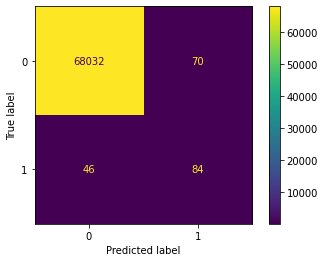

In [ ]:
from sklearn import metrics

clf = RandomForestClassifier(n_estimators = 144, min_samples_split = 2, min_samples_leaf = 1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
return_accuracy(y_test, y_pred, verbose=1)
metrics.plot_confusion_matrix(clf, x_test, y_test)

LOOKING FOR OUTLIERS IN THE BALANCED DATASETAND RETUNING THE PARAMETERS

In [ ]:
x_1, y_1, x_0, y_0 = split_importance(training_data, RelKa)

In [ ]:
# split the two classes seperately into train and test set to ensure representation of the minority class
# both in the test set and in the train set
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size=0.4, random_state=42)
x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_0, y_0, test_size=0.4, random_state=42)

x_train = np.concatenate((x_1_train, x_0_train))
y_train = np.concatenate((y_1_train, y_0_train))
x_test = np.concatenate((x_1_test, x_0_test))
y_test = np.concatenate((y_1_test, y_0_test))

In [ ]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(x_train, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [ ]:
x_train, y_train = drop_outliers(x_train, y_train, outliers_indices)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
y_train = split_RelKa(y_train, 0.7)
y_test = split_RelKa(y_test, 0.7)

In [ ]:
x_train, y_train = smote_sf(x_train, y_train, undersample=0.1, oversample=0.3, kneighbors=5, undersampling = PSU_undersampling)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 10, scoring=make_scorer(weighted_balance_average), verbose=10)
rf_random.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=155.
[CV 1/10; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=155;, score=0.983 total time=  17.5s
[CV 2/10; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=155.
[CV 2/10; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=155;, score=0.995 total time=  17.3s
[CV 3/10; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=155.
[CV 3/10; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=155;, score=0.994 total time=  17.5s
[CV 4/10; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=155.
[CV 4/10; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=155;, score=0.997 total time=  18.0s
[CV 5/10; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=155.
[CV 5/10; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=155;, score=0.

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 111, 122, 133,
                                                         144, 155, 166, 177,
                                                         188, 200]},
                   scoring=make_scorer(weighted_balance_average), verbose=10)

In [ ]:
print(rf_random.best_params_)

{'n_estimators': 155, 'min_samples_split': 5, 'min_samples_leaf': 1}


The number of true negatives is: 68032
The number of false negatives is: 45
The number of false positives is: 70
The number of true positives is: 85
The accuracy is: 0.9983145738070114
The accuracy on the 1's is  0.6538461538461539
The accuracy on the 0's is  0.9989721300402338


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


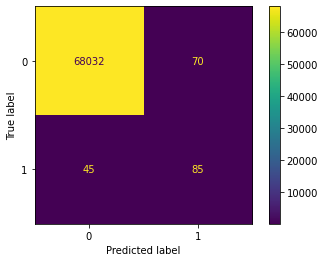

In [ ]:
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=155, min_samples_split=5, min_samples_leaf=1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
return_accuracy(y_test, y_pred)
metrics.plot_confusion_matrix(clf, x_test, y_test)

UNDERSAMPLING BY RANDOM UNDER SAMPLER

In [ ]:
# we don't perform a classical random splitting of train and test as we want the majority of the 1's in the test to see the accuracy of the model on those
import random


critical_indices = np.where(RelKa >= 0.6)[0]
random_subsample = random.sample(list(np.arange(len(critical_indices))), np.int(0.7 * len(critical_indices)))
training_critical_indices = []
for i in range(len(critical_indices)):
    if i not in random_subsample:
      training_critical_indices.append(i)
critical_subsample = training_data[critical_indices[0] + random_subsample, :]
critical_RelKa = RelKa[critical_indices[0] + random_subsample]
X_test = np.zeros(training_data.shape[1])
X_test = X_test[..., np.newaxis].T
y_test = np.array([])
X_train = np.zeros(training_data.shape[1])
X_train = X_train[..., np.newaxis].T
y_train = np.array([])
X_test = np.concatenate([X_test, critical_subsample], axis=0)
y_test = np.concatenate([y_test, critical_RelKa])
X_train = np.concatenate([X_train, training_data[critical_indices[0] + training_critical_indices, :]], axis=0)
y_train = np.concatenate([y_train, RelKa[critical_indices[0] + training_critical_indices]])
X_test = np.delete(X_test, 0, axis=0)
X_train = np.delete(X_train, 0, axis=0)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(267, 318) (267,) (622, 318) (622,)


In [ ]:
non_critical_indices = np.where(RelKa < 0.6)[0]
non_critical_training_data = training_data[non_critical_indices, :]
non_critical_RelKa = RelKa[non_critical_indices]
non_critical_X_train, non_critical_X_test, non_critical_y_train, non_critical_y_test = train_test_split(non_critical_training_data, non_critical_RelKa, train_size=0.7, random_state=42) 

In [ ]:
X_train = np.concatenate([X_train, non_critical_X_train], axis=0)
X_test = np.concatenate([X_test, non_critical_X_test], axis=0)
y_train = np.concatenate([y_train, non_critical_y_train])
y_test = np.concatenate([y_test, non_critical_y_test])
y_train = split_RelKa(y_train, 0.6)
y_test = split_RelKa(y_test, 0.6)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'classifier__n_estimators': n_estimators,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

rus = RandomUnderSampler
smo = SMOTE()
rfc = RandomForestClassifier()

In [ ]:
def cross_validate(X, y, random_grid, undersampling=True, oversampling=True):
    if oversampling is False:
        pipeline = Pipeline([('undersampling', RandomUnderSampler(sampling_strategy = 0.02)), ('classifier', RandomForestClassifier())])
    elif undersampling is False:
        pipeline = Pipeline([('smt', SMOTE(sampling_strategy = 0.8)), ('classifier', RandomForestClassifier())])
    else:
        pipeline = Pipeline([('undersampling', RandomUnderSampler(sampling_strategy = 0.02)), ('smt',  SMOTE(sampling_strategy = 0.8)), ('classifier', RandomForestClassifier())])
    
    rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=random_grid, n_iter=5, cv=10, scoring='roc_auc', verbose=10)
    rf_random.fit(X, y)
    return rf_random.best_params_

In [ ]:
best_params = cross_validate(X_train, y_train, random_grid)

{'classifier__n_estimators': 122, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2}


In [ ]:
clf = RandomForestClassifier(n_estimators=122, min_samples_leaf=2, min_samples_split=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

NameError: ignored

In [ ]:
return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 50904
The number of false negatives is: 460
The number of false positives is: 4
The number of true positives is: 162
The accuracy is: 0.9909955365806327
The accuracy on the 1's is  0.2604501607717042
The accuracy on the 0's is  0.999921426887719


0.9909955365806327